In [1]:
import subprocess
import os
import json
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from jupyterthemes import jtplot
jtplot.style()

path_base = 'D:/Workspace/BSU-Parallel-Computing/Lab3'

In [2]:
def call(n, threads, save=True):
    path = os.path.join(path_base, 'Release/Lab3.exe')
    with open(os.path.join(path_base, 'Release/Lab3.pg'), 'w') as f:
        f.write(f'local {threads-1}')
    s = 1 if save else 0
    return subprocess.call([path, str(n), str(s)])

def test(n_range, t_range, verbose=False):
    vals = np.zeros((len(n_range),len(t_range),4))
    for j, t in enumerate(t_range):
        for i, n in enumerate(n_range):
            if verbose: 
                print(f"n = {n}; threads = {t}")
            to_validate = n<3000
            while call(n, t, save=to_validate):
                pass
            with open('time.json') as json_file:
                data = json.load(json_file)
            vals[i,j,0] = data['total']
            vals[i,j,1] = data['backward']
            vals[i,j,2] = np.mean([
                data[f'computation_{p}']
                for p in range(t)
            ])
            vals[i,j,3] = np.mean([
                data[f'communication_{p}']
                for p in range(t)
            ])
            if to_validate:
                print(validate())
    return vals

def validate():
    fpath = os.path.join(path_base,'A.txt')
    A = np.loadtxt(fpath, dtype=float, skiprows=1)
    fpath = os.path.join(path_base,'x.txt')
    x = np.loadtxt(fpath, dtype=float, skiprows=1)
    return np.max(np.abs(np.linalg.solve(A[:,:-1], A[:,-1]) - x))

In [3]:
n_range = [2000]
t_range = [1]

In [4]:
vals = test(n_range, t_range, verbose=True)

n = 2000; threads = 1
4.2743586448068527e-14


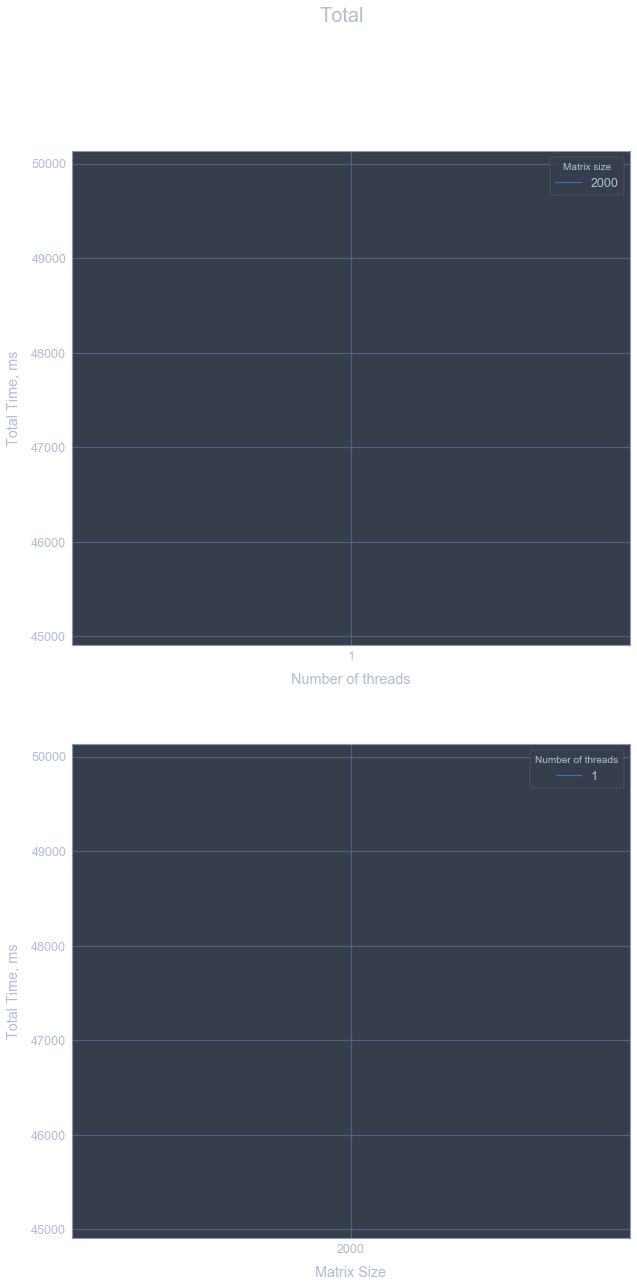

,1
2000,47521.0


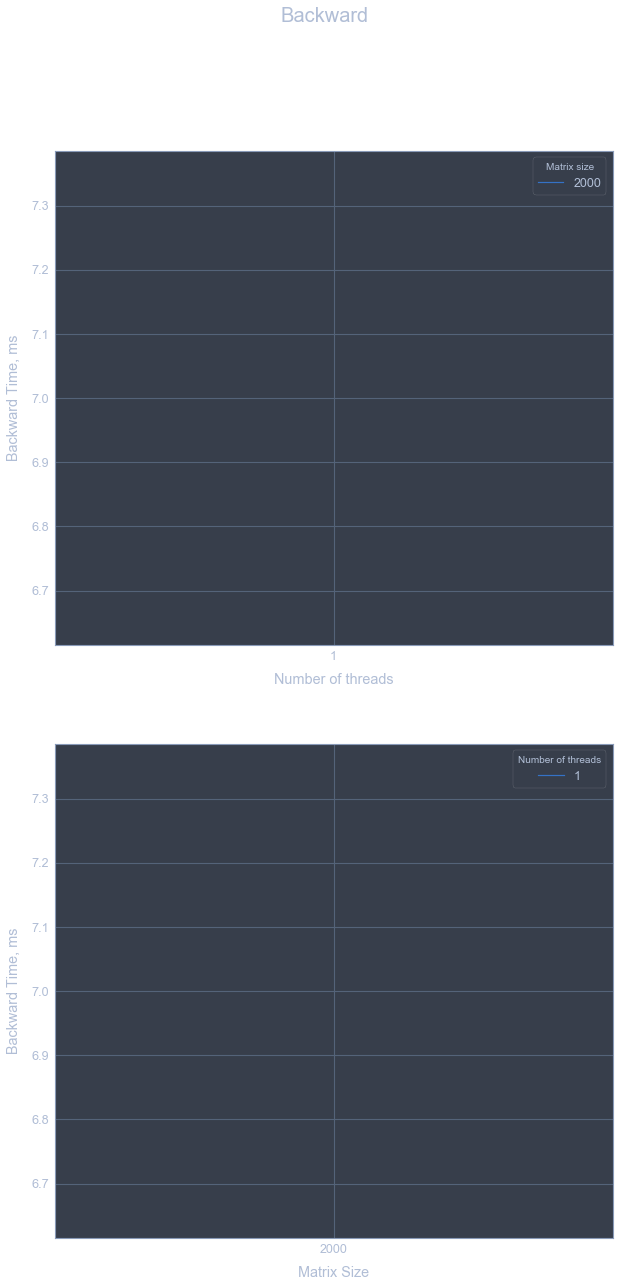

,1
2000,7.0


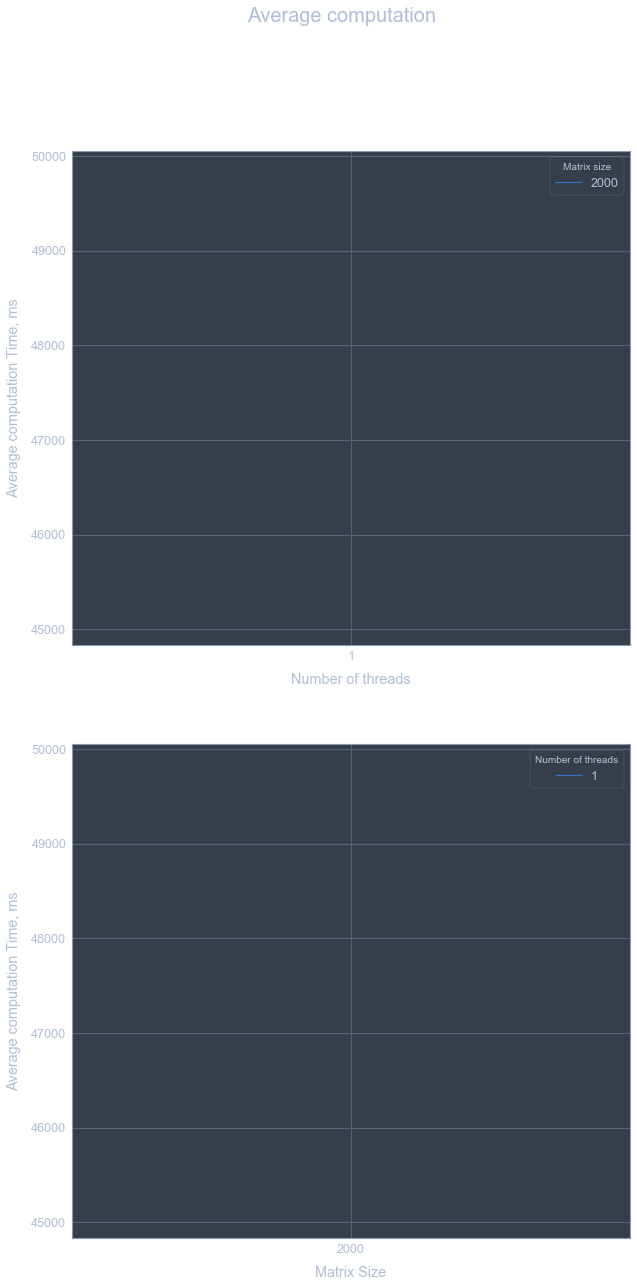

,1
2000,47443.0


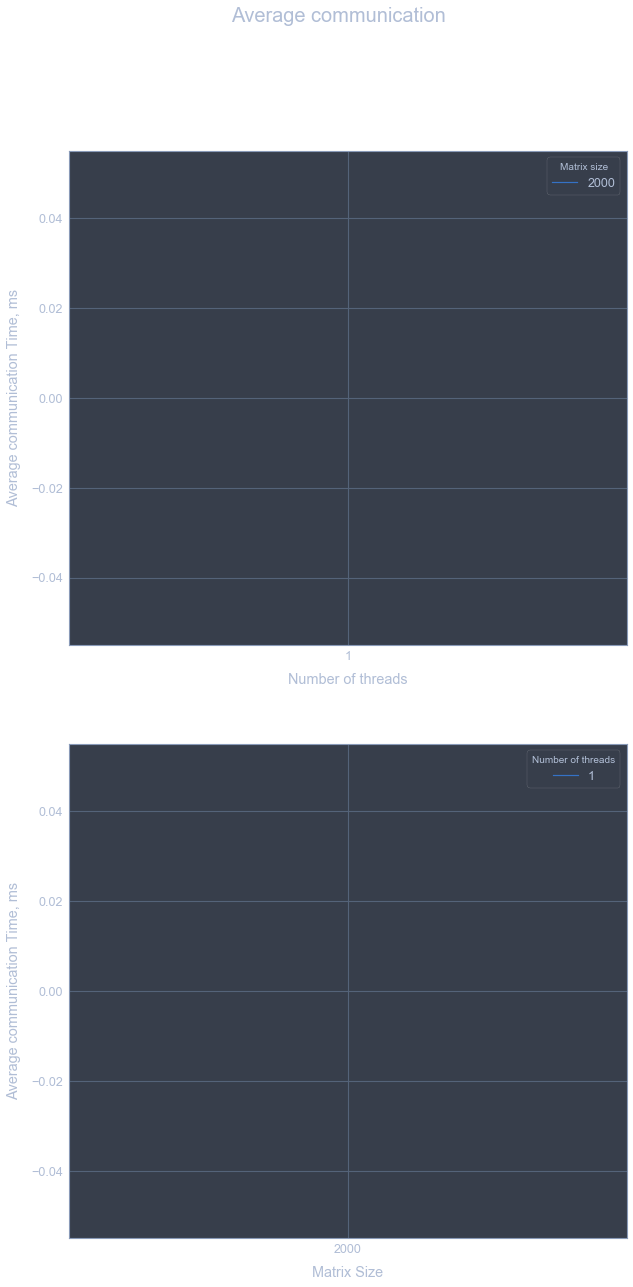

,1
2000,0.0


In [5]:
for k, s in enumerate(['Total', 'Backward', 'Average computation', 'Average communication']):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,20))
    fig.suptitle(s, fontsize=20)
    # By matrix size
    for i, n in enumerate(n_range):
        ax1.plot(t_range, vals[i,:,k])
    ax1.legend(n_range, loc='best', title='Matrix size')
    ax1.set_xlabel('Number of threads',labelpad=10)
    ax1.set_xticks(t_range)
    ax1.set_ylabel(f'{s} Time, ms',labelpad=10)

    # By number of threads
    for j, t in enumerate(t_range):
        ax2.plot(n_range, vals[:,j,k].flatten())
    ax2.legend(t_range, loc='best', title='Number of threads')
    ax2.set_xlabel('Matrix Size',labelpad=10)
    ax2.set_xticks(n_range)
    ax2.set_ylabel(f'{s} Time, ms',labelpad=10)

    plt.show()
    display(pd.DataFrame(data=vals[:,:,k], index=n_range, columns=t_range))